<a href="https://colab.research.google.com/github/munich-ml/MLPy2020/blob/master/22_end2end_ml_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro


## References
Resources used to create this notebook:
- [scikit-learn website](https://scikit-learn.org)
- [Matplotlib website](https://matplotlib.org/)
- [Wikipedia](https://en.wikipedia.org/wiki/Main_Page)
- Hands-on Machine Learning with Scikit-learn, Keras & TensorFlow, Aurelien Geron, [Book on Amazon](https://www.amazon.de/Aur%C3%A9lien-G%C3%A9ron/dp/1492032646/ref=sr_1_3?__mk_de_DE=%C3%85M%C3%85%C5%BD%C3%95%C3%91&dchild=1&keywords=Hands-on+Machine+Learning+with+Scikit-learn%2C+Keras+%26+TensorFlow%2C+Aurelien+Geron%2C&qid=1589875241&sr=8-3)
- Introduction to Machine Learning with Python, Andreas Mueller, [Book on Amazon](https://www.amazon.de/Introduction-Machine-Learning-Python-Scientists/dp/1449369413)


## Setup

First, do the common imports.

Tensorflow must be 2.x, because there are major changes from 1.x

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Forces tensorflow version (only in colab)
%tensorflow_version 2.x           

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import os
import pickle
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(42)

# Setup matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Get munich-ml helper functions from GitHub
if "MLPy2020" in os.listdir():
    !git -C MLPy2020 pull
else:
    !git clone https://github.com/munich-ml/MLPy2020/

from MLPy2020.MLPy_helper_funcs import plot_hist_2D
from IPython.display import Image

Cloning into 'MLPy2020'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 171 (delta 84), reused 68 (delta 20), pack-reused 0
Receiving objects: 100% (171/171), 839.81 KiB | 1.14 MiB/s, done.
Resolving deltas: 100% (84/84), done.


# Get the data

At this point the dataset has already been cloned from GitHub and is located in the `MLPy2020/datasets` subdirectory:

In [2]:
data_dir = os.path.join(os.getcwd(), "MLPy2020", "datasets")
os.listdir(data_dir)

['housing_dataset.pkl', 'logfile.csv']

In [0]:
with open(os.path.join(data_dir, "housing_dataset.pkl"), "rb") as file:
    housing = pickle.load(file)

# A quick look at the data

The **housing dataset** contains house pricing data of about 20K districts in California. The type of the data set is a Pandas DataFrame:

In [5]:
type(housing)

pandas.core.frame.DataFrame

In [6]:
housing.tail(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND
20639,-121.24,39.37,16.0,2785.0,616.0,1387.0,530.0,2.3886,89400.0,INLAND


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Interpreting the `tail` and `info` printout:
- Each row (Index in Pandas) represents one district (one measurement in general)
- Each column represents one **attribute**
- The units of the attributes are mostly arbitrary
- The `total_bedrooms` attribute seems to be incomplete
- All attributes are numeric (`Dtype=float64`), except for `ocean_proximity`

The `ocean_proximity` attribute contains text. 

It is no arbitrary text, but **cathegorical**:



In [11]:
set(housing["ocean_proximity"])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [12]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

## Attribute histograms

Pandas offers build-in histgramm plots of all columns:

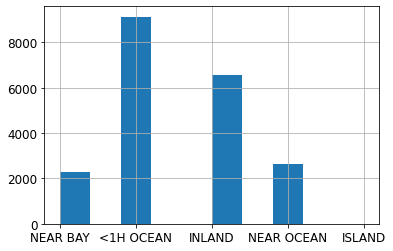

In [13]:
housing["ocean_proximity"].hist();

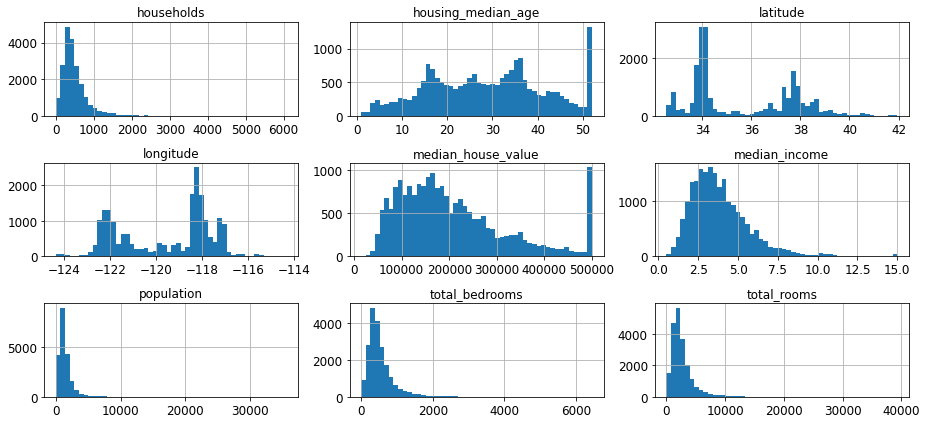

In [14]:
housing.hist(bins=50, figsize=(13, 6))
plt.tight_layout();  

#### Observations

- `median_income` can't be US$ or €. It's actually scaled and capped at 15 (for high incomes) and 0.5 (for low incomes)
- obviously `housing_median_age` and `medial_house_value` are capped, too. Could become a problem beause:

>- `medial_house_value` will later be the **target attribute**, also called **label**
>- the number of capped samples is significant




# Split data into **training** and **test** data


It is time to split the data set into a **training set** and a **test set** for final evaluation / test. 

 

In [0]:
Image(os.path.join("MLPy2020", "images", "split_train_test.png"))

### Why splitting test data so early ?

- Humans are strong in pattern recognition
- If the entire dataset is studied thoroughly, the data scientist may chose a paricular model that **overfits**
- The **generalization error** would be estimated too optimistic and the system would perform worse than expected on new data



## Unterstanding `train_test_split`

In [0]:
from sklearn.model_selection import train_test_split

train_test_split features:
- Easy to use 'one-liner'
- **Randomly** splits data in an arbitrary size
- Reproducable splitting, so the model doesn't see more of the full dataset on each execution
- Multiple datasets can be split on the same indices (e.g. `features` and `labels`)

### Simple `train_test_split` evaluation

Let's generate some simple artificial data to evaluate `train_test_split`

In [0]:
N = 300
feature = np.arange(0, N, step=1)   # 0..N
labels = np.zeros_like(feature)
labels[feature > feature.max() * 2/3] = 1

In [0]:
dataset = pd.DataFrame(np.column_stack([feature, labels]), columns=["feature", "labels"])
dataset.iloc[[0, 1, 199, 200, -2, -1], :]

... we generated a simple dataset with the 200 labels being 0's followd by 100 1's.

The data will be splitted into a `train_set` and a `test_set` both having the length of 150 (because `test_size=0.5`).

In [0]:
train_set, test_set = train_test_split(dataset, test_size=0.5, random_state=4711)
train_set.head()

In [0]:
train_set.hist(figsize=[10, 1.5]);

In [0]:
test_set.hist(figsize=[10, 1.5]);

In [0]:
dataset.hist(figsize=[10, 1.5]);

`test_train_split` worked, because:
- both subsets are ramdomly shuffled
- each of the subsets `train_set` and `test_set` contains about 100 0's and 50 1's
- executing `test_train_split` multiple times returns identical results

## Unterstanding `StratifiedShuffleSplit`

**Stratified sampling** ensures that the feature 
distributions are **representative**. 

The `test_train_split` function we used before didn't split the dataset represantatively:

In [0]:
train_set["labels"].sum()

In [0]:
test_set["labels"].sum()

... `54 / 46` instead of `50 / 50` is a significant difference and is called **sampling bias**.

The sampling bias effect is typically worse for smaller datasets.

Scikit-Learn incorporates the `StratifiedShuffleSplit` class, unfortunatelly without a handy one-liner function such as `test_train_split`. Thus the code is more complex:

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=23)
for train_index, test_index in split.split(dataset, dataset["labels"]):
    strat_train_set = dataset.loc[train_index]
    strat_test_set = dataset.loc[test_index]

Checking the subsets reveals a perfectly representative `50 / 50` split: 

In [0]:
strat_train_set["labels"].sum()

In [0]:
strat_test_set["labels"].sum()

In [0]:
strat_train_set.hist(figsize=[10, 1.5]);

In [0]:
strat_test_set.hist(figsize=[10, 1.5]);

## Applying `StratifiedShuffleSplit`

Applying `StratifiedShuffleSplit` to the housing data is a bit more complicated than for the simple `dataset`. It has to be decided on which feature to stratify on, an that feature needs to be *categorical*.

In this example:
- `"median_income"` is chosen a *stratification feature*
- `pd.cut` is used to cut is in bins in order to have it  *categorical*

The following code 
- adds a new cathegorical feature `income_cat`
- splits the `housing` dataset representatively to `income_cat`
- and removes `income_cat` at the end


In [0]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)    

In [0]:
strat_test_set.shape

The test subset needs to be kept for later use!


In [0]:
strat_train_set.shape


The training subset is small enough to explore is small enough to explore is directly. Otherwise we would split a smaller *exploration subset*.

Now, we copy the training subset back to the more descriptive `housing` variable.

In [0]:
housing = strat_train_set.copy()

# Explore the data

There is geographical information in the dataset, so let's plot the map:

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1);

... use transparency (`alpha=0.1`) to see high-density areas better.

The following graph puts more information in the 2D graph:
- color: `median_house_value`, the target / label
- size: `population` of the district

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             figsize=(10, 7), c="median_house_value", cmap=plt.cm.jet, colorbar=True, sharex=False);

Bugfix: Use `sharex=False`, otherwise the x-axis values and legend are not displayed (https://github.com/pandas-dev/pandas/issues/10611). 



The graph is even more self-explaining when overlayed with a map. In this example, the map is loaded as an image (`california.png`) and "aligned-by-hand":

In [0]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, 
             figsize=(10, 7), c="median_house_value", cmap=plt.cm.jet, colorbar=True, sharex=False)

plt.imshow(mpl.image.imread(os.path.join("MLPy2020", "images", "california.png")), 
           extent=[-124.55, -113.80, 32.45, 42.05]);

# plt.show()

## Interpreting the map

- the `median_house_prices` are strongly related to location
- `ocean_proximity` could be helpful. Although there are low-value coastal areas, as well.
- a clustering algorithm should easily find high price areas and a new features with distances to these cluster centers would be useful 

## Correlations 

Computing the correlation coefficients is easy (at least for not too large datasets) and can provide insides to feature-to-feature and feature-to-target assiciations. 


### Correlation coefficient
A **correlation coefficient $p$** shows how much two features' movements are associated *linearly*:

- $abs(p) < 0.1$: No relevant linear correlation
- $p > 0.5$: Strong plositive linear correlation
- $p < -0.5$: Strong negative linear correlation


#### Correlation of arbitrary functions

Let's simulate some arbitraty funcitons to get a feeling for the correlation coefficients:

In [0]:
x = np.linspace(start=-1, stop=0.85, num=100)
np.random.seed(42)
noise = 0.4 * np.random.randn(x.size)
df = pd.DataFrame(np.column_stack([ x , 0.33*x,   x*x    ,  -x  ,  noise ,  x + noise]), 
                          columns=["x", "pos" ,  "square", "neg", "noise", "pos+noise"])
df.plot(style=".");

Panda DataFrames include a `corr` method for computing the pairwise correlation coefficients of the columns:

In [0]:
df.corr()["x"]

Result discussion:
- Full correlation (+/-1) is given, regardless of the slope: E.g. $p(0.33*x)=p(x)=1$
- The `square` function exebits a relatively weak **linear** correlation (Strongly depencent on the x-axis section)
- Although quite noisy the `pos+noise` correlation is very strong.



### Applying `corr` to the `housing` dataset

In [0]:
housing.head(3)

In [0]:
corr_matrix = housing.corr()
corr_matrix

A heatmap of the correlation matrix is easier to evaluate. 

`Matplotlib` can show bitmaps by using the `imshow()` method. If the bitmap is a NumPy matrix you may call it a heatmap: 

In [0]:
plt.imshow(corr_matrix, cmap=plt.cm.bwr)
plt.xticks(range(len(corr_matrix.columns)), labels=corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), labels=corr_matrix.index)
plt.clim([-1, 1])
plt.colorbar();

#### Evaluating the heatmap

1. There is a strong correlation between the four features `total_rooms`, `total_bedrooms`, `population` , `households`.

1. Also there is a strong negative correlation between `longitude` and `latitude`. This can be understood from the map of California from the previous chapter.

1. `median_house_value` is the **target**. Thus, features with high (positive or negative) correlation with `median_house_value` are of interest. The following sorted output shows that only `median_income` correlates significantly:

#### Correlation with "median_house_value"

The important correlation coefficients are those referencing to `median_house_value`:

In [0]:
corr_with_house_value = corr_matrix["median_house_value"].drop("median_house_value")
corr_with_house_value.sort_values(ascending=False)

In [0]:
corr_with_house_value.sort_values().plot.barh(grid=True);

#### Interactive correlation matrix (optional)
For the usec-case of inspecting the four high-correlation-features in more detail, this subchapter adds interactive sliders to the color scale.

In [0]:
from ipywidgets import interact
from ipykernel.pylab.backend_inline import flush_figures

In [0]:
def plot_corr_matrix(color_min=-1, color_max=1):
    plt.imshow(corr_matrix.values, cmap="bwr")
    ticks = corr_matrix.columns
    plt.xticks(ticks=range(len(ticks)), labels=ticks, rotation=90)
    plt.yticks(ticks=range(len(ticks)), labels=ticks)
    plt.clim([color_min, color_max])
    plt.colorbar()
    flush_figures();

In [0]:
interact(plot_corr_matrix, color_min=(-1, 1, 0.01), color_max=(-1, 1, 0.01));

## Scatter matrix

Pandas build-in `scatter_matrix` method allows quick visual evaluation of feature distributions and correlations:

In [0]:
pd.plotting.scatter_matrix(housing, figsize=(15, 10), alpha=0.25, hist_kwds={"bins":25});

...one can clearly see the high correlation within the "4x4 center".

Let's look at a subset of the attributes more closely:

In [0]:
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8), alpha=0.25, hist_kwds={"bins":50});

Detailed evaluation of the __target__ `median_house_value` with the best-correlating __feature__ `median_income`:


In [0]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.2, figsize=(9, 6), s=20);

###plot observations
What can be learned from the scatter-plot? 


- there is a strong correlation
- there seems to be a cap at y=500k (horizontal line)
- there are more horizontal lines (e.g. at 350k) which are probably artificial

### 2D histogram and contour plots

Plotting alternatives with `matplotlib`

In [0]:
plot_hist_2D(housing, "median_income", "median_house_value", bins=25, figsize=[12, 5])

## Experimenting with feature combinations

Sometimes feature combinations are more useful in predicting the target, as the features by themself. 

An examples: `total_rooms` is the total number of rooms in a district. Dividing `total_rooms` by `households` (the number of households in the district) yields `rooms_per_household` and is probably more helpful in predicting the value of the house.


Before adding new features, let's make a copy of the `housing` dataset:

In [0]:
housing_copy = housing.copy(deep=True)

This, again, are the correlation coefficients of the native features:

In [0]:
corr_matrix = housing_copy.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

Adding new features:

In [0]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

... Note how readable the calculations are, using Pandas DataFrames.

Correlations coefficients including the new features:

In [0]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

Alternative (manual) printout that marks new features

In [0]:
new_features = set(housing.columns).difference(set(housing_copy.columns))
corr_dict = corr_matrix["median_house_value"].sort_values(ascending=False).to_dict()
for key, val in corr_dict.items():
    if key in new_features:
        print("{:30s}{:.3f}  <-- new feature --".format(key, val))
    else:
        print("{:30s}{:.3f}".format(key, val))

###  New features scatter matrix (optional)

In [0]:
features = ["median_house_value"] + list(new_features)
pd.plotting.scatter_matrix(housing[features], figsize=(13, 8), alpha=0.5, hist_kwds={"bins":50});

# Prepare the data for Machine Learning algorithms

Seprerate **features** and **labels** in the training set:

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [0]:
housing.shape

In [0]:
housing_labels.shape

In [0]:
housing_labels.head()

##Data cleaning

###Missing values

Most Machine Learning algorithms cannot work with missing valus. 

As seen before, the `total_bedrooms` feature contains missing values:

In [0]:
housing.info()

**Find incomplete rows using `pd.DataFrame.isnull()` method**

In [0]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head(3)
sample_incomplete_rows

#### Option 1: Drop rows 

Drop incomplete rows using `dropna()`

In [0]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # option 1

#### Option 2: Drop features


Drop incomplete features using `drop()`

Default axis is `0` or `index`, meaning rows.

Therefore chose `axis=1` or `column`.


In [0]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # option 2

#### Option 3: `df.fillna()` 

Fill missing values using `fillna()` 
Assume the missing value to be zero, the mean, the median, etc

In [0]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # option 3
sample_incomplete_rows

As can be seen, imputing the median worked fine, BUT
- the median needs to be saved to fill-in missing values during prediction!
- during prediction, other features may contain missing values.

Thus, it's recommended to use existing **imputer** class, such as Scikit-learn's `SimpleImputer`

#### Option 4: `SimpleImputer`


Fill missing values with Scikit-Learn `SimpleImputer`


In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Remove the text attribute because median can only be calculated on numerical attributes:


In [0]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.columns

In [0]:
imputer.fit(housing_num)

... upon `imputer.fit()` the median of each attribute has been computed and stored in the `statistics_` variable:

In [0]:
imputer.statistics_

The missing values are replaced using `transform` method:

In [0]:
X = imputer.transform(housing_num)

The result is a plain NumPy array and needs to be converted back to a pandas DataFrame.

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

Let's check the result on the `sample_incomplete_rows` subset:


In [0]:
housing_tr.loc[sample_incomplete_rows.index.values]

In [0]:
housing_tr.head(3)

###Handling Text and Categorical Attributes

Most Machine Learning algorithms requires numerical data.

The *housing dataset* contains one text feature `ocean_proximity`:

In [0]:
housing_cat = housing[("ocean_proximity")]
housing_cat.head(8)

The `ocean_proximity` feature is not arbitrary text. There are a limited number of possible values, each representing a *category*.

Use `set()` type-casting or the `Pandas.Series.unique` method get the *unique* values of a collection: 

In [0]:
set(housing["ocean_proximity"])

#### Ordinal encoder

The `OrdinalEncoder` replaces the category text by numbers.



In [0]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_enc = OrdinalEncoder()
housing_cat_encoded = ordinal_enc.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_encoded.squeeze()

Is this what we want? Probably not, because the Machine Learning algorithm that two nearby values are somehow similar. This might be desired in cases of sorted categories, but it usually isn't. In those cases, a `OneHotEncoder` can be used.

####OneHotEncoder

In [0]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat.values.reshape(-1, 1))
housing_cat_1hot

For memory reasons, the `OneHotEncoder` class returns a **sparse scipy array** instead of a **dense numpy array**.

Conversion to a dense array is provided by the `toarray()` method:


In [0]:
housing_cat_1hot.toarray()

In [0]:
cat_encoder.categories_

## Custom transformers

Further up this script we found **feature combinations** to be potentially helpful for predicting the target. 

Such **custom transformation functionality** can seamlessly work with **Scikit-Learn pipelines** by creating a **custom transformer class**.



In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttrAdder(BaseEstimator, TransformerMixin):
    # column index
    INDEXES = {"rooms": 3, "bedrooms": 4, "population": 5, "households": 6}     

    def __init__(self):  # no *args or **kargs
        pass

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        i = CombinedAttrAdder.INDEXES
        rooms_per_household = X[:, i["rooms"]] / X[:, i["households"]]
        population_per_household = X[:, i["population"]] / X[:, i["households"]]
        bedrooms_per_room = X[:, i["bedrooms"]] / X[:, i["rooms"]]
        
        return np.column_stack((X, rooms_per_household, population_per_household, 
                                bedrooms_per_room))


Instanciate the new Transformer class: 


In [0]:
attr_adder = CombinedAttrAdder()
housing_extra_attr = attr_adder.fit_transform(housing.values)

Scikit-Learn transformers receive and return Numpy arrays. 



In [0]:
pd.DataFrame(housing_extra_attr).head()  # Conversion to DataFrame only for pretty plotting

You have to keep track of the columns names, manually. This can easily get messy!

In [0]:
housing_columns = list(housing.columns) + ["rooms_per_household", "population_per_household", 
                                           "bedrooms_per_room"]

In [0]:
housing_extra_attr = pd.DataFrame(housing_extra_attr, columns=housing_columns, index=housing.index)
housing_extra_attr.head()

... the resulting `housing_extra_attr` DataFrame contains the original as well as the extra attributes.

## Feature scaling

Most Machine Mearning algorithms require some kind of **features scaling**. With features of very different scales, they don't predict well or even don't converge at all. 

Some algorithms even require all features to be in the range of 0...1.

A notable exception are **decision tree algorithms** that are robust to arbitrarily scaled data.

In [0]:
housing.hist(bins=50, figsize=(13, 5))
plt.tight_layout();

... yes, the scales of our `housing` dataset features are very different. Thus, scaling those features is requried.

Scikit-Learn provides various scalers, while the two common ones are `MinMaxScaler` and `StandardScaler`:  



In [0]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, QuantileTransformer

Creating `plot_scaled_feature_hist`, a convinience function to evaluate the scalers' results:

In [0]:
def plot_scaled_feature_hist(scaler=None):
    df = housing.drop("ocean_proximity", axis=1)  # dropping the non-numeric feature
    if scaler is not None:
        df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    df.hist(bins=50, figsize=(13, 5))
    plt.tight_layout();

The scaler is fitted only to the training data, excluding the test data! 

After `scalter.fit(training_data)`, the scalining parameters (`min, max, scale` in case of `MinMaxScaler`) are stored within the scaler object.

Those parameters can later be reused for transformations of test data or new data (in production). 

For comparison to the scaled features, let's plot the original histograms ones again:

In [0]:
plot_scaled_feature_hist(scaler=None)  # original data without scaling

In [0]:
plot_scaled_feature_hist(scaler=MinMaxScaler())

... all features are scaled between 0 and 1.

Let's compare to *standardization*:

In [0]:
plot_scaled_feature_hist(scaler=StandardScaler())

... The results of `MinMaxScaler` and `StandardScaler` are very similar, just scale and offset are different.

These *linear scalers* preserve the original distribution. Sometimes odd distributions, such as the `total_bedrooms` disctibution shoud be avoided. The `QuantileTransformer` shapes the output distribution gaussion / `normal` or `uniform`:  



In [0]:
plot_scaled_feature_hist(scaler=QuantileTransformer(output_distribution="normal"))

In [0]:
plot_scaled_feature_hist(scaler=QuantileTransformer(output_distribution="uniform"))

# Transformation pipelines

`Pipeline` is a Scikit-Learn class that executes data transformation steps in a defined order.

In [0]:
from sklearn.pipeline import Pipeline

The Pipeline constructor expects a list of name, transformer tuples:

In [0]:
num_pipe = Pipeline([('imputer', SimpleImputer(strategy="median")),
                     ('attr_adder', CombinedAttrAdder()),
                     ('std_scaler', StandardScaler())])

Having generated the `num_pipi` pipeline, allows calling `fit()` and `fit_transform` on the pipeline object:

In [0]:
housing_num_tr = num_pipe.fit_transform(housing_num)

## Pipeline with categorical features

It would be even more convenient to have one combined pipeline for all features, numerical and categorical ones. Scikit-Learn's `ColumnTransformer` does exactly this.

In [0]:
from sklearn.compose import ColumnTransformer

In [0]:
num_attr = list(housing_num.columns)
cat_attr = ["ocean_proximity"]

In [0]:
full_pipe = ColumnTransformer([("num", num_pipe, num_attr),
                               ("cat", OneHotEncoder(), cat_attr)])

housing_prep = full_pipe.fit_transform(housing)

In [0]:
housing.shape

### Quiz
`housing` has 9 columns. How many does `housing_prep` have? 

In [0]:
housing_prep.shape

- 4 additional columns because of the `OneHotEncoder`: $number\_of\_categories - 1$
- 2 additional columns because of the `CombinedAttrAdder`. 3 in case of `add_bedrooms_per_room=True`



Again, we have to keep track of the column names manually:

In [0]:
pd.Series(housing_columns)   # pd.Series() used for pretty output, only

The extra attributes are in, but no yet the categorical attribus ...

In [0]:
cat_encoder = full_pipe.named_transformers_["cat"]
cat_columns = list(cat_encoder.categories_[0])
cat_columns

In [0]:
housing_prep_columns = housing_columns + cat_columns
housing_prep_columns.remove("ocean_proximity")
pd.Series(housing_prep_columns)   # pd.Series() used for pretty output, only

# Select and train a model 

## Linear regression model

In [0]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prep, housing_labels);

... done! We got a simple but working Linear Regression. Let's try it on some instances from the test set:

In [0]:
n = 5
some_labels = strat_test_set["median_house_value"].iloc[:n]
some_data = strat_test_set.drop("median_house_value", axis=1).iloc[:n]
some_data_prep = full_pipe.transform(some_data)
some_predictions = lin_reg.predict(some_data_prep)

Note the beaty of the transformation pipeline. All data preparations are executed by simply calling `full_pipe.transform()`.

Now let's see how well it predicts:

In [0]:
a_trial = pd.DataFrame(np.column_stack((some_labels.values, some_predictions)), 
                       columns=["labels", "predictions"])
a_trial

In [0]:
a_trial.plot("labels", "predictions", kind="scatter", grid=True, figsize=(5,2.5));

Not bad for a first trial and such a simple model!



## Root mean squared error

Scikit-Learn provides the `mean_squared_error` as a function, an NumPy will compute the square root:

$$\text{MSE}(y_\text{true}, y_\text{pred}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_\text{true} - y_\text{pred})^2$$


In [0]:
from sklearn.metrics import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print("RMSE={:.1f}".format(rmse))
    return rmse

Let's measure the RMSE on the entire training set:

In [0]:
housing_predictions = lin_reg.predict(housing_prep)
lin_rmse = root_mean_squared_error(housing_labels, housing_predictions);

... is that number ok?

The RSME is the typical error of the prediction. It is an absolute accuracy measure, so we have to compare it's size to the labels size:

In [0]:
housing_labels.hist(bins=30, figsize=(10,2), label="labels histogram")
plt.plot([0, lin_rmse], [500, 500], linewidth=3, label="RMSE")
plt.xlabel("median house value"), plt.legend();

The RSME looks quite significant, when plotting it on top of the labels histogram. 

Thus, let's try a different model...

## Decisition tree model

A decision tree is a powerful machine learning model, capable of finding complex nonlinear relationships in the data. But for now, let's just use it and see how it performs:

In [0]:
from sklearn.tree import DecisionTreeRegressor

In [0]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prep, housing_labels)

In [0]:
tree_rmse = root_mean_squared_error(housing_labels, tree_reg.predict(housing_prep));

No error at all! 

We found the perfect model! ... Most likely not.

It is far more likely, that the model has badly overfit the data. In other words, the model just memorized the data without much generalization capability.

How can we be sure? 



## Model validation

How to **validate** model (e.g. *linear regression model* `lin_reg` and *decision tree model* `tree_reg`) without touching the **test set**?

Remember, the test set should be preserved for a final test right before going to production.

One common solution is to split the entire data set into 3 subsets:

In [0]:
Image(os.path.join("MLPy2020", "images", "split_train_valid_test.png"))

### Cross validation


The k-fold **cross validation** trains and validates a model k-times, each time with a differnet validation subset (called 'fold'). 

In [0]:
Image(os.path.join("MLPy2020", "images", "split_cross_val.png"))

- **advantage**: Cross validation provides not only the performance measure, but also an estimate of how precise that measure is (e.g. as a standard deviation).

- **disadvantage**: Cross validation executes `k`-times, so it may take a long time to finish.

In [0]:
from sklearn.model_selection import cross_val_score

In [0]:
# cross_val_score wrapper
# conveniently returning RSME (root mean squared error) as mean and standard
# deviation of the folds
def cross_validation(*args, **kwargs):
    scores = cross_val_score(*args, **kwargs,
                             scoring="neg_mean_squared_error")
    rmse = np.sqrt(-scores)
    print("Cross val mean(RMSE)={:.1f}, std(RMSE)={:.1f}".format(rmse.mean(), 
                                                                    rmse.std()))
    return {"mean":rmse.mean(), "std":rmse.std()}

In [0]:
tree_val_rsme = cross_validation(tree_reg, housing_prep, housing_labels, cv=5)

Now, the *decision tree model* doesn't look as good anymore. 

- test / **in-sample** RSME is 0
- validation / **out-of-sample** RSME is large
- that model is clearly **overfitting** the data

It is even worse that the simple *linear regression model*:

In [0]:
lin_val_rmse = cross_validation(lin_reg, housing_prep, housing_labels, cv=5)

## Random forest regression model

[Random forests on scikit-learn.org](https://scikit-learn.org/stable/modules/ensemble.html#forest)

In [0]:
from sklearn.ensemble import RandomForestRegressor

In [0]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(housing_prep, housing_labels)
forest_rmse = root_mean_squared_error(housing_labels, forest_reg.predict(housing_prep));

In [0]:
forest_val_rmse = cross_validation(forest_reg, housing_prep, housing_labels, cv=5)

## Support vector machine model

[SVM on scikit-learn.org](https://scikit-learn.org/stable/modules/svm.html#svm)

In [0]:
from sklearn.svm import SVR

In [0]:
svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prep, housing_labels)
svm_rmse = root_mean_squared_error(housing_labels, svm_reg.predict(housing_prep))

In [0]:
svm_val_rmse = cross_validation(svm_reg, housing_prep, housing_labels, cv=5)

## Comparing the models

In [0]:
pd.DataFrame([[lin_rmse, lin_val_rmse["mean"]], 
              [tree_rmse, tree_val_rsme["mean"]],
              [forest_rmse, forest_val_rmse["mean"]],
              [svm_rmse, svm_val_rmse["mean"]]],
             columns = ["in-sample RSME", "out-of-sample RSME"],
             index = ["linear regression", "decision tree", "random forest", "linear SVM"])

For now, the **random forest** is the most promising model. The fact that it's still overfitting shows that it can be further improved by **contraining**, or training to more data (which is often not possible).

# Tune the model

**Tuning** the model means optimizing a **score** by varying the **hyperparameters**. In the *housing example* it's the RMSE that should be optimized / minimized.  

Tuning can be done manually or by using automized tools such as `GridSearchCV` or `RandomizedSearchCV`.

## GridSearchCV

The Scikit-Learn `GridSearchCV` automizes the tuning process:
- receive an `estimator` / a model to be tuned
- *fit* data to the model and *score* the predictions (the scorer ist set by `scoring`)
- execute the procedure for each combination of the `param_grid`
- *cross validation* is executed on each step with `cv` defining the number of *folds*


In [0]:
from sklearn.model_selection import GridSearchCV
GridSearchCV?

Select an *estimator* / model and the respective *parameter grid* to be tuned:

In [0]:
forest_reg = RandomForestRegressor(random_state=42)

In [0]:
param_grid = {'n_estimators': [3, 10, 30], 
              'max_features': [2, 5, 8],
              'bootstrap': [True, False]}

Note on **execution time**:

The `param_grid` in this example has `3 * 3 * 2 = 18` combinations and the cross validation folds are set `cv = 5` thus the time consuming training will be executed 90 times! 

The `verbose` parameter can be set (e.g. 1000) to get more info during execution. Using that it is easy to observe, that more complex models require more execution time.

In [0]:
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, return_train_score=True,
                           scoring='neg_mean_squared_error', verbose=0)

grid_search.fit(housing_prep, housing_labels);

### Evaluate `GridSearchCV` results

The best hyperparameter combination found:

In [0]:
grid_search.best_params_

Details on the *cross validation* results are also available as `dict`. Converting to a `DataFrame` makes it more readable:

In [0]:
pd.DataFrame(grid_search.cv_results_)

#### `get_best_of_cv_results` 
Even as a `DataFrame` this is hard to evaluate.

**Challenge**: Write a `get_best_of_cv_results` function, that:
- takes the `dict` `grid_search.cv_results_` as input
- converts it to a `pandas.DataFrame`
- removes all unnecessary columns. Only keep those starting with `param_`
- creates a `RSME` column: `RSME = squareroot(- mean_test_score)`
- sorts by `RSME` with having the best on top
- returns that beautified `DataFrame`

In [0]:
def get_best_of_cv_results(results_dict):
    df_all = pd.DataFrame(results_dict)

    # select the columns to be kept
    cols = ["mean_test_score"]
    for col in df_all.columns:
        if col.startswith("param_"):
            cols.append(col)
    df = df_all.loc[:, cols]

    # convert negative mean squared error to RMSE
    df["RMSE"] = np.sqrt(-df["mean_test_score"])
    df.drop(labels="mean_test_score", axis=1, inplace=True)

    # sort by RMSE
    df.sort_values(by="RMSE", inplace=True)
    
    return df

In [0]:
get_best_of_cv_results(grid_search.cv_results_)

Once we got a `DataFrame` it is relatively easy to also plot the result:

In [0]:
df = get_best_of_cv_results(grid_search.cv_results_)
df.plot.scatter(x="param_max_features", y="param_n_estimators", 
                c="RMSE", s=100, cmap=mpl.cm.coolwarm,
                figsize=(10,3), grid=True);

Obervation: The more complex the model gets, the better it predicts.

### Best estimator

The **best estimator** found during `GridSearchCV` is dirctly available ...


In [0]:
grid_search.best_estimator_

## RandomizedSearchCV

`RandomizedSearchCV` implements a random alterative to the `GridSearchCV`. It is advantageous is case of many parameters and combinations and easier to scale to the available compute resources. 

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In contrast to the `param_grid` of `GridSearchCV`, the `RandomizedSearchCV` expects a `param_distributions` `dict` with each `value` being a `list` or a distribution such as `scipy.stats.distributions`:

In [0]:
from scipy.stats import randint

param_distributions = {'n_estimators': randint(low=5, high=30),
                       'max_features': randint(low=1, high=8)}

In [0]:
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions, n_iter=15, cv=5, 
                                scoring='neg_mean_squared_error', random_state=42,
                                verbose=0)
rnd_search.fit(housing_prep, housing_labels);

### Evaluate `RandomizedSearchCV` results

In [0]:
df = get_best_of_cv_results(rnd_search.cv_results_)
df.plot.scatter(x="param_max_features", y="param_n_estimators", 
                c="RMSE", s=100, cmap=mpl.cm.coolwarm,
                figsize=(10,3), grid=True)
df

Again, more complex models predict better than simple ones.

## Feature importance

The model we tuned with `GridSeachCV` and `RandomizedSearchCV` is the `RandomForestRegressor`. As a bycatch, that model indicates how important every feature is for making accurate predictions. Let's view them:


In [0]:
grid_search.best_estimator_.feature_importances_

... for easy evaluation we need the column names along with the `feature_importances_` and also have them sorted: 

In [0]:
importances = pd.Series(grid_search.best_estimator_.feature_importances_, 
                        index=housing_prep_columns)
importances.sort_values(inplace=True)
importances.plot.barh(grid=True, title="feature importance");

### Evaluation

- `median_incame` stays the most important feature. This is somehow expected from the `corr_matrix` evaluation
- all three added features are in the upper half
- the `INLAND` 'bit' is 2nd most important. However, it seams all other categories could be dropped without losing much.

Let's plot again the linear correlations to the original features, for comparison:

In [0]:
title = "linear correlation to the median house value"
corr_with_house_value.abs().sort_values().plot.barh(grid=True, title=title);

... interrestingly, the worst correlating feature `population_per_household` became the 3rd most important feature, at least for the `RandomForestRegressor` model. 

Complex non-linear models don't rely on simple linear relationship!

### Potential future improvements

- dropping unimportant features
- solve the clipping issue (esp. at 500.000)
- clean the data further (e.g. remove outliers)
- investigate the bad predictions and understand the root cause

# Final test

After tweaking your models for a while, you eventually decide that one of them performs *sufficiently* well. Then it's time to evaluate that final model with the test set. 

Once again, that must be the final step. Don't optimize any further on the test set!

In [0]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prep = full_pipe.transform(X_test)   # not .fit_transform() !
final_predictions = final_model.predict(X_test_prep)

final_rmse = root_mean_squared_error(y_test, final_predictions)

your model is ready for production!